In [1]:
import numpy as np
import seaborn as sns  # noqa
import matplotlib.pyplot as plt  # noqa

from sklearn.datasets import fetch_lfw_people

In [2]:
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

n_samples, h, w = faces.images.shape

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


**每一幅图的尺寸为[62*47],大约3000个像素值**

**人脸实例**

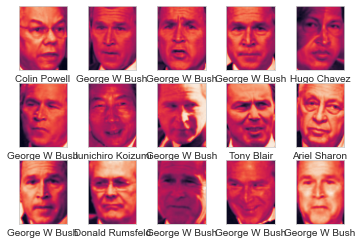

In [3]:
fig, ax = plt.subplots(3, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i])
    axi.set(
        xticks=[],
        yticks=[],
        xlabel=faces.target_names[faces.target[i]]
    )

将数据分为训练和测试数据集

In [4]:
from sklearn.model_selection import train_test_split

x_train, x_test, ytrain, ytest = train_test_split(faces.data, faces.target, random_state=42)
print(x_train.shape)
print(x_test.shape)

(1011, 2914)
(337, 2914)


可以将整个图像平展为一个长度为3000左右的一维向量，然后使用这个向量作为特征。通常更有效的方法时通过预处理提取图像最重要的特征。一个重要的特征提取方法时PCA，可以将一幅图像转换为一个长度为更短的向量

In [5]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA

n_components = 150
print(f"从 {x_train.shape[0]} 张人脸图片中提取出 top {n_components} eigenfaces")
pca = PCA(
    n_components=n_components,
    svd_solver="randomized",
    whiten=True,
    random_state=42
)
pca.fit(x_train)

eigen_faces = pca.components_.reshape((n_components, h, w))

print("将输入数据投影到eigen faces的标准正交基")

x_train_pca = pca.transform(x_train)
x_test_pca = pca.transform(x_test)

从 1011 张人脸图片中提取出 top 150 eigenfaces
将输入数据投影到eigen faces的标准正交基


先使用线性svm尝试，作为baseline

In [6]:
svc = SVC(kernel="linear", C=10)
svc.fit(x_train_pca, ytrain)
yfit = svc.predict(x_test_pca)

In [7]:
from sklearn.metrics import classification_report
print(classification_report(ytest, yfit, target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.62      0.67      0.65        15
     Colin Powell       0.76      0.85      0.81        68
  Donald Rumsfeld       0.76      0.81      0.78        31
    George W Bush       0.86      0.80      0.83       126
Gerhard Schroeder       0.72      0.78      0.75        23
      Hugo Chavez       0.93      0.70      0.80        20
Junichiro Koizumi       0.92      0.92      0.92        12
       Tony Blair       0.81      0.83      0.82        42

         accuracy                           0.81       337
        macro avg       0.80      0.80      0.79       337
     weighted avg       0.81      0.81      0.81       337



调参：通过交叉验证寻找最佳的kernel，和其他参数。

注意：C（控制间隔的大小）

In [8]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {"kernel": ["linear"], "C": [1, 5, 10, 50]},
    {"kernel": ["rbf"], "C": [1, 5, 10, 50], "gamma": [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]},
    {"kernel": ["poly"], "C": [1, 5, 10, 50], "degree": [2, 3, 4], "gamma": ["auto"]}
]

grid = GridSearchCV(SVC(class_weight="balanced"), param_grid, cv=5)

grid.fit(x_train_pca, ytrain)
print(grid.best_estimator_)
print(grid.best_params_)

SVC(C=10, class_weight='balanced', gamma=0.001)
{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}


In [9]:
model = grid.best_estimator_
yfit = model.predict(x_test_pca)

使用训练好的SVM做预测

Text(0.5, 0.98, 'Predicted Names; Incorect Labels in Red')

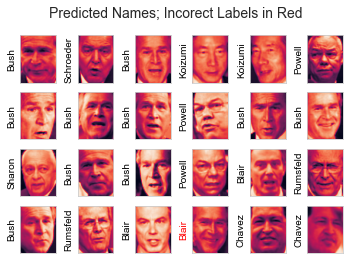

In [10]:
fig, ax  = plt.subplots(4, 6)
for i, axi in enumerate(ax.flat):
    axi.imshow(x_test[i].reshape(62, 47))
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(
        faces.target_names[yfit[i]].split()[-1],
        color="black" if yfit[i] == ytest[i] else "red"
    )
fig.suptitle("Predicted Names; Incorect Labels in Red", size=14)

生成性能报告

In [11]:
from sklearn.metrics import classification_report
print(classification_report(ytest, yfit, target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.65      0.73      0.69        15
     Colin Powell       0.80      0.87      0.83        68
  Donald Rumsfeld       0.74      0.84      0.79        31
    George W Bush       0.92      0.83      0.88       126
Gerhard Schroeder       0.86      0.83      0.84        23
      Hugo Chavez       0.93      0.70      0.80        20
Junichiro Koizumi       0.92      1.00      0.96        12
       Tony Blair       0.85      0.95      0.90        42

         accuracy                           0.85       337
        macro avg       0.83      0.84      0.84       337
     weighted avg       0.86      0.85      0.85       337



混淆矩阵

Text(92.68, 0.5, 'predicted label')

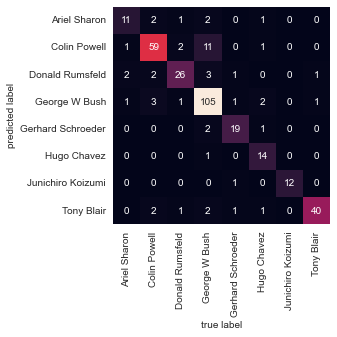

In [12]:
from sklearn.metrics import confusion_matrix

mat = confusion_matrix(ytest, yfit)
sns.heatmap(
    mat.T,
    square=True,
    annot=True,
    fmt="d",
    cbar=False,
    xticklabels=faces.target_names,
    yticklabels=faces.target_names
)
plt.xlabel("true label")
plt.ylabel("predicted label")